The formula used for the double dots is $\vec{F}=-Gm_{1}m_{2}/r^2*\hat{r}$
I decomposed $\hat{r}$ to get the double dots for x1, y1, etc. 
 $\hat{r}=(x1-x2)/r*\hat{i}+...$

In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [52]:
# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

In [53]:
class orbit:
    
    def __init__(self, m1, m2, G=1):
        self.m1 = m1
        self.m2 = m2
        self.G = G
        
    def du_dt(self, t, u):
        """
        This function returns the right-hand side of the diffeq
        u = [x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot]
        """
        m1 = self.m1
        m2 = self.m2
        G = self.G
        r = np.sqrt((u[0]-u[4])**2 + (u[2]-u[6])**2)
        
        x1_double_dot = -(G*m2/r**3) * (u[0]-u[4])
        y1_double_dot = -(G*m2/r**3) * (u[2]-u[6])
        x2_double_dot = (G*m1/r**3) * (u[0]-u[4])
        y2_double_dot = (G*m1/r**3) * (u[2]-u[6])
        
        return [u[1], x1_double_dot, u[3], y1_double_dot, u[5], x2_double_dot, u[7], y2_double_dot]
    
    def solve_ode(self, t_pts, u0, 
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        u = u0
        solution = solve_ivp(self.du_dt, (t_pts[0], t_pts[-1]), 
                             u, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = solution.y

        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
    
    def solve_ode_Leapfrog(self, t_pts, u0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the output arrays
        x1 = np.zeros(len(t_pts))
        x1_dot = np.zeros(len(t_pts))
        y1 = np.zeros(len(t_pts))
        y1_dot = np.zeros(len(t_pts))
        x2 = np.zeros(len(t_pts))
        x2_dot = np.zeros(len(t_pts))
        y2 = np.zeros(len(t_pts))
        y2_dot = np.zeros(len(t_pts))
        
        #initial conditions
        x1[0] = u0[0]
        x1_dot[0] = u0[1]
        y1[0] = u0[2]
        y1_dot[0] = u0[3]
        x2[0] = u0[4]
        x2_dot[0] = u0[5]
        y2[0] = u0[6]
        y2_dot[0] = u0[7]
        
        # step through the differential equation
        for i in np.arange(len(t_pts) - 1):
            t = t_pts[i]
            u = [x1[i], x1_dot[i], y1[i], y1_dot[i], x2[i], x2_dot[i], y2[i], y2_dot[i]]
            du_dt = self.du_dt(t, u)
            
            x1_dot_half = x1_dot[i] + du_dt[1] * delta_t/2
            y1_dot_half = y1_dot[i] + du_dt[3] * delta_t/2
            x2_dot_half = x2_dot[i] + du_dt[5] * delta_t/2
            y2_dot_half = y2_dot[i] + du_dt[7] * delta_t/2
            
            x1[i+1] = x1[i] + x1_dot_half * delta_t
            y1[i+1] = y1[i] + y1_dot_half * delta_t
            x2[i+1] = x2[i] + x2_dot_half * delta_t
            y2[i+1] = y2[i] + y2_dot_half * delta_t
            
            u = [x1[i+1], x1_dot[i], y1[i+1], y1_dot[i], x2[i+1], x2_dot[i], y2[i+1], y2_dot[i]]
            du_dt = self.du_dt(t, u)
            
            x1_dot[i+1] = x1_dot_half + du_dt[1] * delta_t/2
            y1_dot[i+1] = y1_dot_half + du_dt[3] * delta_t/2
            x2_dot[i+1] = x2_dot_half + du_dt[5] * delta_t/2
            y2_dot[i+1] = y2_dot_half + du_dt[7] * delta_t/2
            
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot

In [54]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

Here, I will set second mass to be much smaller than the first mass. 

In [55]:
# Labels for individual plot axes
x_vs_time_labels = ('t', 'x')
x_dot_vs_time_labels = (r'$t$', r'$d\x/dt$')
#state_space_labels = ('', '')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 25.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# the masses of the two objects
m1 = 1
m2 = 0.001

# Instantiate a orbit
p1 = orbit(m1, m2)

In [56]:
#initial conditions
#y1_dot_0 is nonzero to keep the total momentum equal to zero so the orbits dont move
x1_0, x1_dot_0 = 0, 0
y1_0, y1_dot_0 = 0, -0.0008
x2_0, x2_dot_0 = 1, 0
y2_0, y2_dot_0 = 0, 0.8

u0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]

#Solve
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = p1.solve_ode(t_pts, u0)

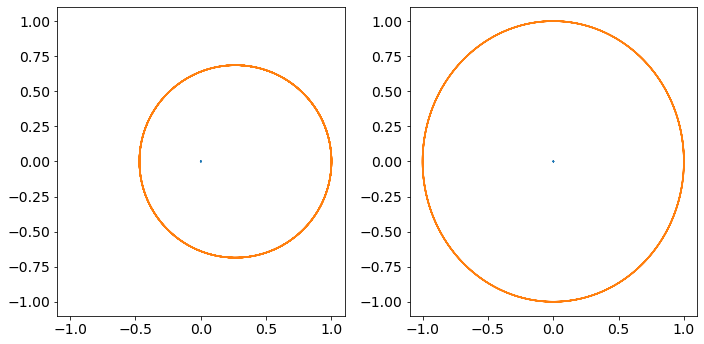

In [57]:
# start the plot!
fig = plt.figure(figsize=(10,5))

# first plot: eliptical orbit
ax_a = fig.add_subplot(1,2,1)  
ax_a.plot(x1, y1)
ax_a.plot(x2, y2)
ax_a.set_xlim([-1.1, 1.1])
ax_a.set_ylim([-1.1, 1.1])

u0[3] = -0.001
u0[7] = 1
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = p1.solve_ode(t_pts, u0)

#second plot: circular orbit
ax_b = fig.add_subplot(1,2,2)  
ax_b.plot(x1, y1)
ax_b.plot(x2, y2)
ax_b.set_xlim([-1.1, 1.1])
ax_b.set_ylim([-1.1, 1.1])

fig.tight_layout()

Above, you can see that when one mass is much larger than the other, then this reduces to a simple case of one body orbiting the other fixed body like the ones we covered in class. If you increace the second mass, you get a clearly different result as shown below:

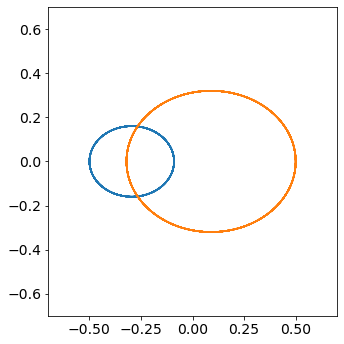

In [58]:
m1 = 1
m2 = 0.5

p2 = orbit(m1, m2)

#initial conditions
x1_0, x1_dot_0 = -0.5, 0
y1_0, y1_dot_0 = 0, -0.25
x2_0, x2_dot_0 = 0.5, 0
y2_0, y2_dot_0 = 0, 0.5

u0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]

#Solve
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = p2.solve_ode(t_pts, u0)

#Plot
# start the plot!
fig2 = plt.figure(figsize = (5,5))

# Plot 3: Neither mass is much larger than the other
ax_c = fig2.add_subplot(1,1,1)  
ax_c.plot(x1, y1)
ax_c.plot(x2, y2)
ax_c.set_xlim([-0.7, 0.7])
ax_c.set_ylim([-0.7, 0.7])

fig2.tight_layout()
#the two masses orbit each other. Blue: larger mass, Orange: smaller mass (m2)

Here, I solve the same orbits using the Leapfrog method. 

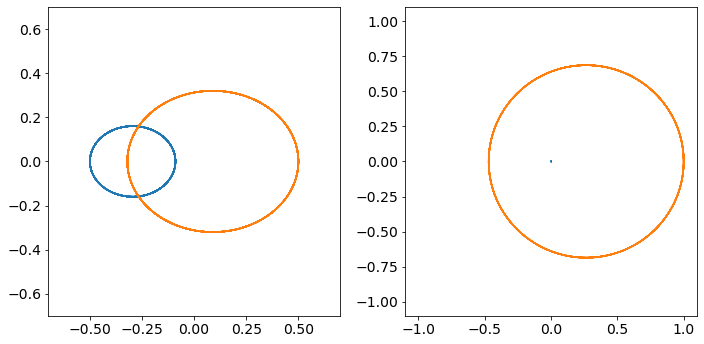

In [59]:
#initial conditions
x1_0, x1_dot_0 = -0.5, 0
y1_0, y1_dot_0 = 0, -0.25
x2_0, x2_dot_0 = 0.5, 0
y2_0, y2_dot_0 = 0, 0.5

u0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]

#Solve
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = p2.solve_ode_Leapfrog(t_pts, u0)

#Plot with m2=0.5m1
fig3 = plt.figure(figsize = (10,5))

ax_d = fig3.add_subplot(1,2,1)  
ax_d.plot(x1, y1)
ax_d.plot(x2, y2)
ax_d.set_xlim([-0.7, 0.7])
ax_d.set_ylim([-0.7, 0.7])

#plot again for circular orbits and m2<<m1
x1_0, x1_dot_0 = 0, 0
y1_0, y1_dot_0 = 0, -0.0008
x2_0, x2_dot_0 = 1, 0
y2_0, y2_dot_0 = 0, 0.8

u0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]

x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = p1.solve_ode_Leapfrog(t_pts, u0)

ax_e = fig3.add_subplot(1,2,2)  
ax_e.plot(x1, y1)
ax_e.plot(x2, y2)
ax_e.set_xlim([-1.1, 1.1])
ax_e.set_ylim([-1.1, 1.1])

fig3.tight_layout()

In [60]:
#calculate total energy
E = []
for n in range(len(t_pts)):
    r = np.sqrt((x1[n]-x2[n])**2 + (y1[n]-y2[n])**2)
    E_pot = -p1.G*p1.m1*p1.m2/r
    K = 0.5*p1.m1*(x1_dot[n]**2 + y1_dot[n]**2) + 0.5*p1.m2*(x2_dot[n]**2 + y2_dot[n]**2)
    E.append(E_pot + K)

C:\Users\David Gough\AppData\Local\Temp\ipykernel_10872\1853022086.py:4: RuntimeWarning: divide by zero encountered in log10
  delta_E.append(np.log10(abs(n-E[0])))
C:\Users\David Gough\AppData\Local\Temp\ipykernel_10872\1853022086.py:25: RuntimeWarning: divide by zero encountered in log10
  delta_E.append(np.log10(abs(n-E[0])))


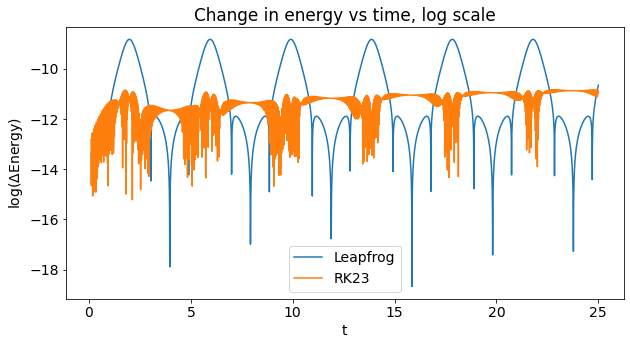

In [27]:
#Compare the change in energy for P1 (m2<<m1) 
delta_E = []
for n in E:
    delta_E.append(np.log10(abs(n-E[0])))
    
start, stop = start_stop_indices(t_pts, 0.1, 25)   

#plot_y_vs_x(t_pts, delta_E)
fig4 = plt.figure(figsize=(10,5))
ax_f = fig4.add_subplot(1,1,1)  
ax_f.plot(t_pts[start:stop], delta_E[start:stop], label='Leapfrog')


x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = p1.solve_ode(t_pts, u0)

E = []
for n in range(len(t_pts)):
    r = np.sqrt((x1[n]-x2[n])**2 + (y1[n]-y2[n])**2)
    E_pot = -p1.G*p1.m1*p1.m2/r
    K = 0.5*p1.m1*(x1_dot[n]**2 + y1_dot[n]**2) + 0.5*p1.m2*(x2_dot[n]**2 + y2_dot[n]**2)
    E.append(E_pot + K)

delta_E = []
for n in E:
    delta_E.append(np.log10(abs(n-E[0])))
    
ax_f.plot(t_pts[start:stop], delta_E[start:stop], label='RK23')
ax_f.set_title('Change in energy vs time, log scale')
ax_f.set_xlabel('t')
ax_f.set_ylabel(r'log($\Delta$Energy)')
ax_f.legend()

Here, you can see that the RK23 method, which is the default for solve_ivp, does not conserve energy since the change in energy slowly trends up. Meanwhile, the Leapfrog method does since the change in energy does not seem to be trending in any direction.

In [61]:
# Import explicitly the widgets we might use (add more as needed!) 
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout, Tab, Label, Checkbox
from ipywidgets import FloatSlider, IntSlider, Play, Dropdown, HTMLMath 

from IPython.display import display

In [62]:
def update_plot(m2=0.001, y2_dot_0=1,
                lw=2, color='blue'
               ):
    """
    Update the plot, which includes a call to a function.
    Note that the entire plot is redrawn here.
    Now all the parameters controlling the plot are inputs to the function.
    """
    t_start = 0.
    t_end = 100.
    delta_t = 0.001
    
    t_pts = np.arange(t_start, t_end+delta_t, delta_t)  
    
    p4 = orbit(1,m2)
    #initial conditions
    x1_0, x1_dot_0 = 0, 0
    y1_0, y1_dot_0 = 0, -y2_dot_0*m2
    x2_0, x2_dot_0 = 1, 0
    y2_0, y2_dot_0 = 0, y2_dot_0
    
    u0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]
    
    #Solve
    x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = p4.solve_ode(t_pts, u0)
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    #line, = ax.plot(t_pts, phi1, lw=lw, color=color)
    ax.plot(x1, y1, lw=lw, color=color)
    ax.plot(x2, y2, lw=lw, color='red')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    

In [63]:
slider_border = Layout(border='solid 1.0px')

def float_widget(value, min, max, step, description, format):
    """Makes a FloatSlider with the passed parameters and continuous_update
       set to False."""
    return FloatSlider(value=value, min=min, max=max, step=step,
                       disabled=False,
                       description=description, continuous_update=False,
                       orientation='horizontal', layout=slider_border,
                       readout=True, readout_format=format)



y2_dotw = float_widget(value=1, min=0.1, max=2., step=0.1,
                       description=r'$v_{0}$ :', format='.1f')

m2w = float_widget(value=0.001, min=0.001, max=1., step=0.05,
                       description=r'm2 :', format='.1f')



In [64]:
plot_out = widgets.interactive_output(update_plot,
                                      dict(
                                      y2_dot_0=y2_dotw,
                                      m2=m2w,
                                      )
                                     )

In [65]:
hbox_1 = HBox([m2w, y2_dotw])
UI_box = VBox([hbox_1, plot_out])

Interactive widgit: feel free to change the smaller mass and it's initial velocity

In [66]:
display(UI_box)   
#blue is mass 1, while red is the smaller mass 2

Finally, I plot the the simulation of the 3 body problem. implementation of this is not much different from that of the 2 body problem as I only had to add an extra term to x1 and x2 double dot as well as some more variables for the third body. The results, however are very different...

In [67]:
class three_body(orbit):
    
    def __init__(self, m1, m2, m3):
        super().__init__(m1, m2)
        self.m3 = m3
        
    def du_dt(self, t, u):
        """
        This function returns the right-hand side of the diffeq
        u = [x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot, x3, x3_dot, y3, y3_dot]
        """
        m1 = self.m1
        m2 = self.m2
        m3 = self.m3
        G = self.G
        r1 = np.sqrt((u[0]-u[4])**2 + (u[2]-u[6])**2)
        r2 = np.sqrt((u[4]-u[8])**2 + (u[6]-u[10])**2)
        r3 = np.sqrt((u[0]-u[8])**2 + (u[2]-u[10])**2)
        
        x1_double_dot = -(G*m2/r1**3) * (u[0]-u[4]) - (G*m3/r3**3) * (u[0]-u[8])
        y1_double_dot = -(G*m2/r1**3) * (u[2]-u[6]) - (G*m3/r3**3) * (u[2]-u[10])
        x2_double_dot = (G*m1/r1**3) * (u[0]-u[4]) - (G*m3/r2**3) * (u[4]-u[8])
        y2_double_dot = (G*m1/r1**3) * (u[2]-u[6]) - (G*m3/r2**3) * (u[6]-u[10])
        x3_double_dot = (G*m1/r3**3) * (u[0]-u[8]) + (G*m2/r2**3) * (u[4]-u[8])
        y3_double_dot = (G*m1/r3**3) * (u[2]-u[10]) + (G*m2/r2**3) * (u[6]-u[10])
        
        return [u[1], x1_double_dot, u[3], y1_double_dot, u[5], x2_double_dot, u[7], y2_double_dot, u[9], x3_double_dot, u[11], y3_double_dot]
    
    def solve_ode(self, t_pts, u0, 
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        u = u0
        solution = solve_ivp(self.du_dt, (t_pts[0], t_pts[-1]), 
                             u, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot, x3, x3_dot, y3, y3_dot = solution.y

        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot, x3, x3_dot, y3, y3_dot

In [68]:
p3 = three_body(1, 0.5, 0.5)

x1_0, x1_dot_0 = -0.5, -0.1
y1_0, y1_dot_0 = 0, -0.25
x2_0, x2_dot_0 = 0.5, 0.1
y2_0, y2_dot_0 = 0, 0.5
x3_0, x3_dot_0 = 0, 0.1
y3_0, y3_dot_0 = 0.3, 0

u0 = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0, x3_0, x3_dot_0, y3_0, y3_dot_0]

x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot, x3, x3_dot, y3, y3_dot = p3.solve_ode(t_pts, u0)

(-1.1, 1.1)

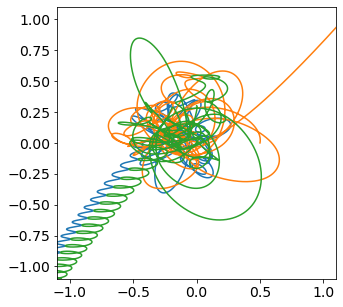

In [69]:
fig5 = plt.figure(figsize=(5,5))

ax_g = fig5.add_subplot(1,1,1)
ax_g.plot(x1, y1)
ax_g.plot(x2, y2)
ax_g.plot(x3, y3)
ax_g.set_xlim([-1.1, 1.1])
ax_g.set_ylim([-1.1, 1.1])